# Поиск аномалий в данных

Для начала создадим синтетический набор данных, который будет содержать только два столбца:

— ФИО сотрудников организации (для 100 человек)

— их ежемесячная заработная плата (в долларах США) в диапазоне от 1000 до 2500.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
plt.style.use('ggplot')

In [5]:
from faker import Faker

In [6]:
Faker.seed(4321)

In [7]:
names_list = []

fake = Faker()
for _ in range(100):
    names_list.append(fake.name())

In [9]:
names_list[:5]

['Jason Brown',
 'Jacob Stein',
 'Cody Brown',
 'Larry Morales',
 'Jessica Hendricks']

In [10]:
np.random.seed(42)
salaries = []
for _ in range(100):
    salary = np.random.randint(1000, 2500)
    salaries.append(salary)

In [11]:
salaries[:5]

[2126, 2459, 1860, 2294, 2130]

In [14]:
##Pandas DataFrame
salary_df = pd.DataFrame(
    {'Person': names_list,
    'Salary (in USD)': salaries
    })

In [15]:
salary_df

,Person,Salary (in USD)
0,Jason Brown,2126
1,Jacob Stein,2459
2,Cody Brown,1860
3,Larry Morales,2294
4,Jessica Hendricks,2130
...,...,...
95,Robert Garrett,2076
96,Parker Kent,1791
97,Michelle Logan,1216
98,Beverly Baker DVM,1763


Давайте вручную изменим зарплату двух человек, чтобы создать выбросы. В реальности это может произойти по ряду причин, например, из-за невнимательности бухгалтера или сбоя программного обеспечения.

In [18]:
salary_df.at[16, 'Salary (in USD)'] = 23
salary_df.at[65, 'Salary (in USD)'] = 17

print(salary_df.loc[16])
print(salary_df.loc[65])

Person             Miss Amanda Harris MD
Salary (in USD)                       23
Name: 16, dtype: object
Person             Joyce Bishop
Salary (in USD)              17
Name: 65, dtype: object


## Находим аномалии с помощью графиков

Обратите внимание на маленький кружок в самом низу. Он сразу даёт понять, что что-то не так, потому что сильно отличается от остальных данных. 

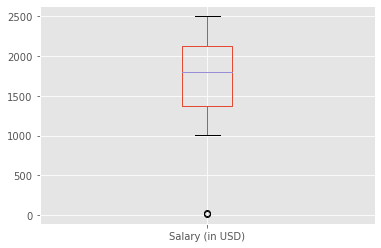

In [19]:
salary_df['Salary (in USD)'].plot(kind='box')

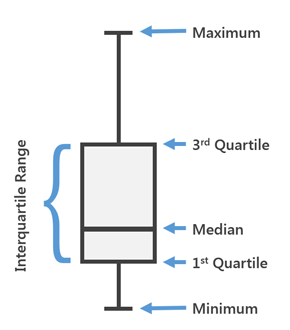

## Гистограмма

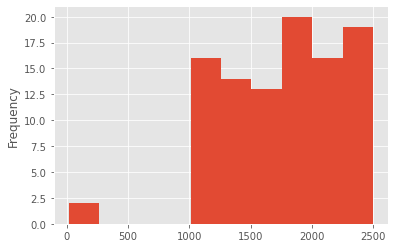

In [20]:
salary_df['Salary (in USD)'].plot(kind='hist')

***Примечание: хотя наш набор данных содержит только один признак (зарплату), в настоящих датасетах аномалии могут встречаться в разных признаках. Но даже там такие визуализации помогут вам их обнаружить.***

# Кластерный подход для обнаружения аномалий

In [26]:
salary_row = salary_df['Salary (in USD)'].values

salary_row = salary_row.reshape(-1,1)
salary_row = salary_row.astype('float64')

In [36]:
from scipy import cluster
from scipy.cluster.vq import kmeans

In [37]:
centroids, avg_distance = kmeans(salary_row, 4)

#### centroids — это центроиды, сгенерированные kmeans, а avg_distance — усреднённое евклидово расстояние между ними и точками.

In [40]:
centroids, avg_distance

(array([[1127.96428571],
        [2062.76190476],
        [2374.45      ],
        [1697.35483871]]),
 115.21835227272727)

извлечём наши кластеры с помощью метода vq(). Его аргументы это:

— точки данных

— центроид, сгенерированный алгоритмом кластеризации.

Метод возвращает группы точек (кластеры) и расстояния между точками и ближайшими кластерами.

In [41]:
groups, cdist = cluster.vq.vq(salary_row, centroids)

In [42]:
groups

array([1, 2, 3, 2, 1, 1, 1, 0, 3, 2, 0, 2, 0, 2, 1, 3, 0, 2, 3, 0, 2, 3,
       0, 1, 1, 0, 1, 3, 2, 0, 0, 3, 3, 3, 1, 3, 2, 3, 1, 0, 1, 3, 1, 3,
       2, 3, 1, 3, 0, 3, 0, 2, 0, 3, 0, 0, 0, 3, 2, 3, 1, 2, 0, 2, 1, 0,
       2, 3, 3, 0, 0, 1, 2, 1, 1, 2, 3, 1, 3, 0, 3, 0, 0, 1, 0, 3, 2, 3,
       2, 2, 1, 0, 3, 0, 3, 1, 3, 0, 3, 0])

In [45]:
cdist

array([  63.23809524,   84.55      ,  162.64516129,   80.45      ,
         67.23809524,   32.23809524,   18.76190476,    6.96428571,
        231.35483871,  136.45      ,  202.03571429,  107.55      ,
         40.96428571,   21.55      ,   60.23809524,  173.64516129,
       1104.96428571,   42.45      ,   71.64516129,  215.03571429,
         62.55      ,  107.64516129,  257.03571429,  152.23809524,
        107.76190476,  148.03571429,  121.23809524,  238.35483871,
         37.45      ,  106.96428571,  124.03571429,   49.64516129,
        158.64516129,  223.35483871,   19.23809524,  187.35483871,
        124.55      ,    1.64516129,   87.76190476,   61.03571429,
        105.76190476,   11.35483871,  105.76190476,  135.35483871,
        107.45      ,  133.64516129,   91.23809524,   51.35483871,
        107.96428571,  142.64516129,   38.03571429,   77.45      ,
        259.03571429,   97.35483871,  187.03571429,  114.96428571,
        113.03571429,   78.64516129,    5.45      ,  133.35483

Text(0, 0.5, 'Indices')

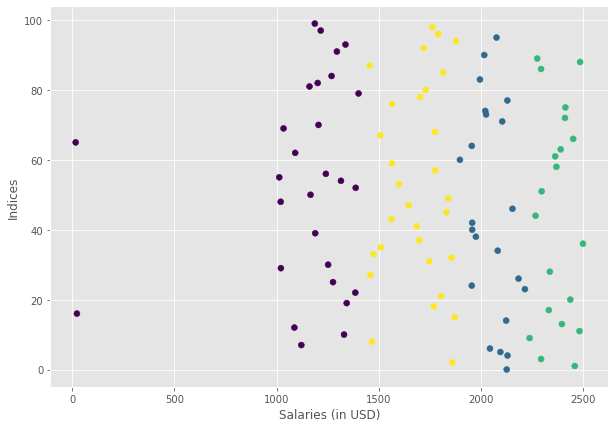

In [48]:
plt.figure(figsize=(10,7))
plt.scatter(salary_row, np.arange(0, 100), c=groups)
plt.xlabel('Salaries (in USD)')
plt.ylabel('Indices')

## Вывод

Теперь вы точно видите аномалии. Итак, несколько моментов, которые необходимо учитывать перед обучением модели:

Тщательно изучите данные — взгляните на каждый признак в наборе, соберите статистику.

Постройте несколько полезных графиков (как показано выше), так вам будет легче заметить отклонения.

Посмотрите, как признаки связаны друг с другом. Это поможет выбрать наиболее значимые из них и отказаться от тех, что не влияют на целевую переменную (не коррелируют с ней). 

In [197]:
mu_1, sigma_1, size = 0, 0.05, 100
mu_2, sigma_2 = 0, 0.1

s_1 = np.random.normal(mu_1, sigma_1, size)
s_2 = np.random.normal(mu_2, sigma_2, size)

##-- Аномалии
# s_1[0] = 2.5
# s_2[0] = -2.5

s = np.append(s_1, s_2)

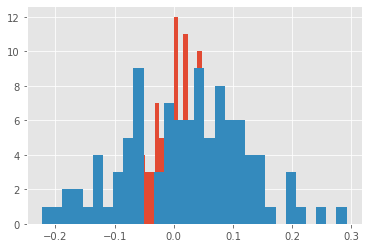

In [204]:
_, bins_1, _ = plt.hist(s_1, 30)
_, bins_2, _ = plt.hist(s_2, 30)

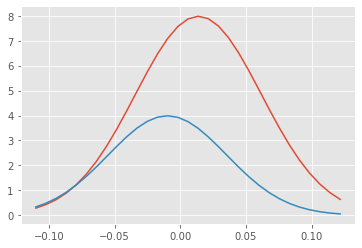

In [205]:
plt.plot(bins, 1/(sigma_1 * np.sqrt(2 * np.pi)) * np.exp( - (bins_1 - mu_1)**2 / (2 * sigma_1**2)))
plt.plot(bins, 1/(sigma_2 * np.sqrt(2 * np.pi)) * np.exp( - (bins_2 - mu_2)**2 / (2 * sigma_2**2)))

In [206]:
s = s.reshape(-1, 1)

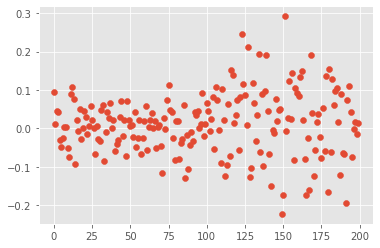

In [207]:
plt.scatter(np.arange(size * 2), s)

In [208]:
from sklearn.mixture import GaussianMixture

In [209]:
gaus = GaussianMixture(n_components=2)
gaus.fit(s)

GaussianMixture(n_components=2)

In [210]:
pred = gaus.predict(s)

In [211]:
pred.shape

(200,)

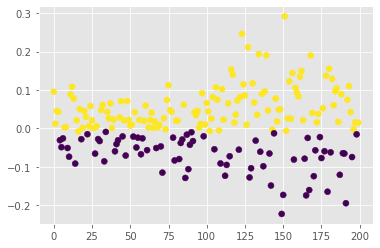

In [212]:
plt.scatter(np.arange(size * 2), s, c=pred)